In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from learn import svd_learn
from data import Mixture, Distribution

In [33]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

2.3161962521785844


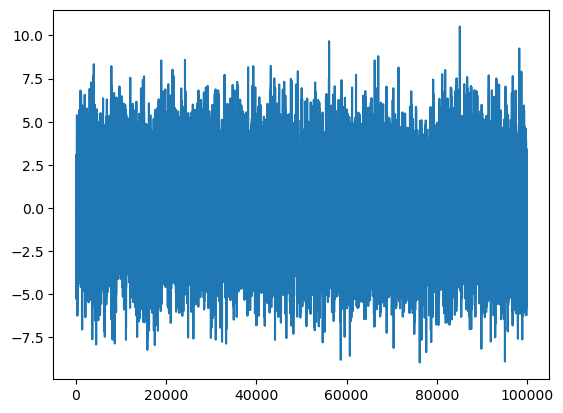

In [2]:
n = 100000
series = np.random.randn(n)

for i in range(n - 1):
    series[i + 1] = 0.9 * series[i] + series[i + 1]
plt.plot(series)
print(series.std())

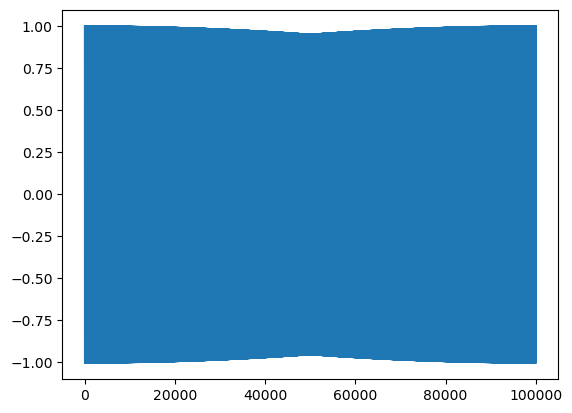

In [3]:
a = np.linspace(0,100000, n)
a = np.cos(a * 2 * np.pi * (1/10) )
plt.plot(a)
seasonal_series = series + a

In [4]:
model = ARIMA(series[:10000], order=(1,0,0), seasonal_order=(1,0,0,10))
model_fit = model.fit()

In [5]:
model_fit.polynomial_ar

array([ 1.        , -0.90076103])

In [6]:
print(np.var(seasonal_series))

5.871547199255043


In [7]:
# internal prediction
pred = model_fit.predict(0,10000)
print(np.abs(pred - seasonal_series[:10001]).mean())

0.9935814882859519


In [8]:
%%capture
# ARIMA cross validation
xs = seasonal_series
predict_sarima = []
window = len(xs)//100
for i in range(100):
    subseq = xs[i:i+window]
    df = pd.DataFrame(subseq)
    mod_sarimax = sm.tsa.SARIMAX(subseq, order=(1,1,1),
                                seasonal_order=(0,1,1,4))
    res_sarimax = mod_sarimax.fit(disp=0)

    #res = mod_sarimax.filter(res_sarimax.params)

    # Show the summary of results
    pred = res_sarimax.get_prediction(window,window).predicted_mean
    
    predict_sarima.append(pred)

In [9]:
predict_sarima = np.array(predict_sarima).squeeze()
print(abs(predict_sarima - xs[window:window+100]).mean())
print(xs[window:window + 100].std())


0.9698516781336837
2.6872497974261877


In [35]:
seasonal_series

array([ 0.929407  ,  0.74735539,  0.29649067, ..., -1.65175581,
       -0.62007078, -0.46605024])

In [10]:
n_states = 20

df = pd.DataFrame(seasonal_series, columns=["data"])
res = pd.qcut(df["data"],n_states, labels=False, retbins=True, precision=3, duplicates='raise')
# do equal-depth p
xs = np.array(list(res[0]))
bins = res[1]


In [11]:
df['Bin'] = pd.qcut(df['data'], n_states, labels=False)

In [12]:
mode = df.groupby('Bin')['data'].apply(lambda x: x.mode().iloc[0]).to_numpy()

In [13]:
from learn import svd_learn, learn_mix_from_seq, likelihood


In [14]:
mode

array([-9.68594563e+00, -3.97984074e+00, -3.10374776e+00, -2.51353224e+00,
       -2.04909363e+00, -1.64656273e+00, -1.28601094e+00, -9.38599276e-01,
       -6.15079928e-01, -3.04340358e-01,  3.99950884e-03,  3.07491845e-01,
        6.22535708e-01,  9.39481493e-01,  1.27852606e+00,  1.64329570e+00,
        2.04848937e+00,  2.52745240e+00,  3.11417876e+00,  3.98978173e+00])

In [15]:
xs

array([12, 12, 10, ...,  4,  7,  8])

In [28]:
%%capture
n_states = [10,20]
#L_chains = [2,3,4,5,6,7]
L_chains = [2,3,4,5,6,7]

mix_err = np.zeros((len(n_states), len(L_chains)))
for i in range(len(n_states)):
    for j in range(len(L_chains)):
        df = pd.DataFrame(seasonal_series, columns=["data"])
        res = pd.qcut(df["data"], n_states[i], labels=False, retbins=True, precision=3, duplicates='raise')
        # do equal-depth p
        xs = np.array(list(res[0]))
        
        bins = res[1]
        df['Bin'] = pd.qcut(df['data'], n_states[i], labels=False)
        mode = df.groupby('Bin')['data'].apply(lambda x: x.mode().iloc[0]).to_numpy()

        num_categories = n_states[i]
        window = len(xs)//100
        L = L_chains[j]
        correct_count = 0
        error = []
        neg_ll = []
        predict = []
        mapped_predict = []
        l1_error = []
        for k in range(100):
            subseq = xs[i:i+window]
            learned_mix = learn_mix_from_seq(subseq,'GKV-SVD', num_categories, L)
            chain_prob = likelihood(learned_mix, np.atleast_2d(subseq[-2:]))
            #most_likely_index = np.argmax(chain_prob)
            #multi_dim_index = np.unravel_index(most_likely_index, learned_mix.S.shape)
            # Based on likelihood probability to find the most likely chain.
            most_likely_chain = np.argmax(chain_prob)
            prob_next_step = learned_mix.Ms[most_likely_chain, subseq[window - 1], :]
            sorted_indices = np.argsort(prob_next_step)
            pred = np.argmax(prob_next_step)
            predict.append(pred)
            #rank = np.where(sorted_indices == xs[i + window])[0][0]
            #error.append(59 - rank)
            mapped_predict.append(mode[pred])
            l1_error.append(abs(mode[pred] - seasonal_series[i + window])) 
        #error = np.array(error)
        mapped_predict = np.array(mapped_predict)
        l1_error = np.array(l1_error)
        mix_err[i,j] = l1_error.mean()
        
        

In [29]:
mix_err

array([[ 2.12172329,  1.0560339 ,  1.0560339 ,  1.0560339 ,  2.12172329,
         2.8916866 ],
       [ 1.02022259, 14.69594995, 14.69594995, 14.69594995, 14.69594995,
        14.69594995]])